In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("preatcher/standard-ocr-dataset")

print("Path to dataset files:", path)

100%|██████████| 46.2M/46.2M [00:00<00:00, 206MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("preatcher/standard-ocr-dataset")

print("Path to dataset files:", path)

In [4]:
dataset_path = "/root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2"
training_data = os.path.join(dataset_path, "training_data")
testing_data = os.path.join(dataset_path, "testing_data")


In [5]:
# Load training data (skip invalid images)
data = []

for label in os.listdir(training_data):
    label_path = os.path.join(training_data, label)

    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            try:
                # Try loading the image to check it's valid
                _ = load_img(img_path, target_size=(32, 32), color_mode="grayscale")
                data.append((img_path, label))
            except Exception as e:
                print(f"⚠️ Skipped invalid image: {img_path} ({e})")


In [6]:
# Create DataFrame for easier processing
df = pd.DataFrame(data, columns=["image_path", "label"])
df.head()


image_path label
0  /root/.cache/kagglehub/datasets/preatcher/stan...     J
1  /root/.cache/kagglehub/datasets/preatcher/stan...     J
2  /root/.cache/kagglehub/datasets/preatcher/stan...     J
3  /root/.cache/kagglehub/datasets/preatcher/stan...     J
4  /root/.cache/kagglehub/datasets/preatcher/stan...     J

In [7]:
# Map characters to integers
characters = list(string.digits + string.ascii_uppercase)
char_to_int = {char: i for i, char in enumerate(characters)}
int_to_char = {i: char for char, i in char_to_int.items()}
num_classes = len(char_to_int)
IMG_SIZE = (32, 32)


In [9]:
def load_images(df):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row["image_path"]
        label = row["label"]

        try:
            label_int = char_to_int[label]
            img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
            labels.append(label_int)
        except Exception as e:
            print(f"⚠️ Skipping invalid image during loading: {img_path} ({e})")

    return np.array(images), np.array(labels)


In [10]:
X_train, y_train = load_images(df)
X_train = X_train.reshape(-1, 32, 32, 1)
y_train = to_categorical(y_train, num_classes)


In [11]:
y_int_labels = np.argmax(y_train, axis=1)
X_train, X_val, y_train_int, y_val_int = train_test_split(
    X_train, y_int_labels, test_size=0.2, stratify=y_int_labels, random_state=42
)
y_train = to_categorical(y_train_int, num_classes)
y_val = to_categorical(y_val_int, num_classes)


In [12]:
model = Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])


In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)


In [15]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val)
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.0738 - loss: 4.3658 - val_accuracy: 0.5347 - val_loss: 2.1531
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2937 - loss: 2.8003 - val_accuracy: 0.8231 - val_loss: 1.0353
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4692 - loss: 2.1289 - val_accuracy: 0.8749 - val_loss: 0.7553
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5602 - loss: 1.7787 - val_accuracy: 0.9084 - val_loss: 0.6155
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6295 - loss: 1.5146 - val_accuracy: 0.9200 - val_loss: 0.5577
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6891 - loss: 1.2857 - val_accuracy: 0.9205 - val_loss: 0.5300
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7290 - loss: 1.1625 - val_accuracy: 0.9336 - val_loss: 0.4881
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7611 - loss: 1.0472 - val_accuracy: 0

In [16]:
model.save("ocr_model_kaggle.keras")


In [2]:
from tensorflow.keras.models import load_model
model=load_model("D:\WORKSPACE\College Project\YOLO+CNN\CNN\ocr_model_kaggle.keras")
print(model.inputs)

model.summary()


[<KerasTensor shape=(None, 32, 32, 1), dtype=float32, sparse=False, name=input_layer>]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 956,270 (3.65 MB)

 Trainable params: 318,692 (1.22 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 637,386 (2.43 MB)

In [17]:
def load_test_images(testing_data_path):
    test_images = []
    test_filenames = []
    actual_labels = []

    for label in os.listdir(testing_data_path):
        label_path = os.path.join(testing_data_path, label)

        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
                    img_array = img_to_array(img) / 255.0
                    test_images.append(img_array)
                    test_filenames.append(img_path)
                    actual_labels.append(label)
                except Exception as e:
                    print(f"⚠️ Skipped invalid test image: {img_path} ({e})")

    return np.array(test_images), test_filenames, actual_labels


In [18]:
X_test, test_filenames, actual_labels = load_test_images(testing_data)
X_test = X_test.reshape(-1, 32, 32, 1)


⚠️ Skipped invalid test image: /root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2/testing_data/G/44404.png (cannot identify image file <_io.BytesIO object at 0x7b89441effb0>)


In [19]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [20]:
int_to_char = {i: c for c, i in char_to_int.items()}
predicted_chars = [int_to_char[i] for i in y_pred_labels]


In [21]:
actual_chars = [label for label in actual_labels]
correct = np.sum(np.array(predicted_chars) == np.array(actual_chars))
accuracy = (correct / len(actual_chars)) * 100
print(f"✅ Test Accuracy: {accuracy:.2f}%")


✅ Test Accuracy: 97.41%


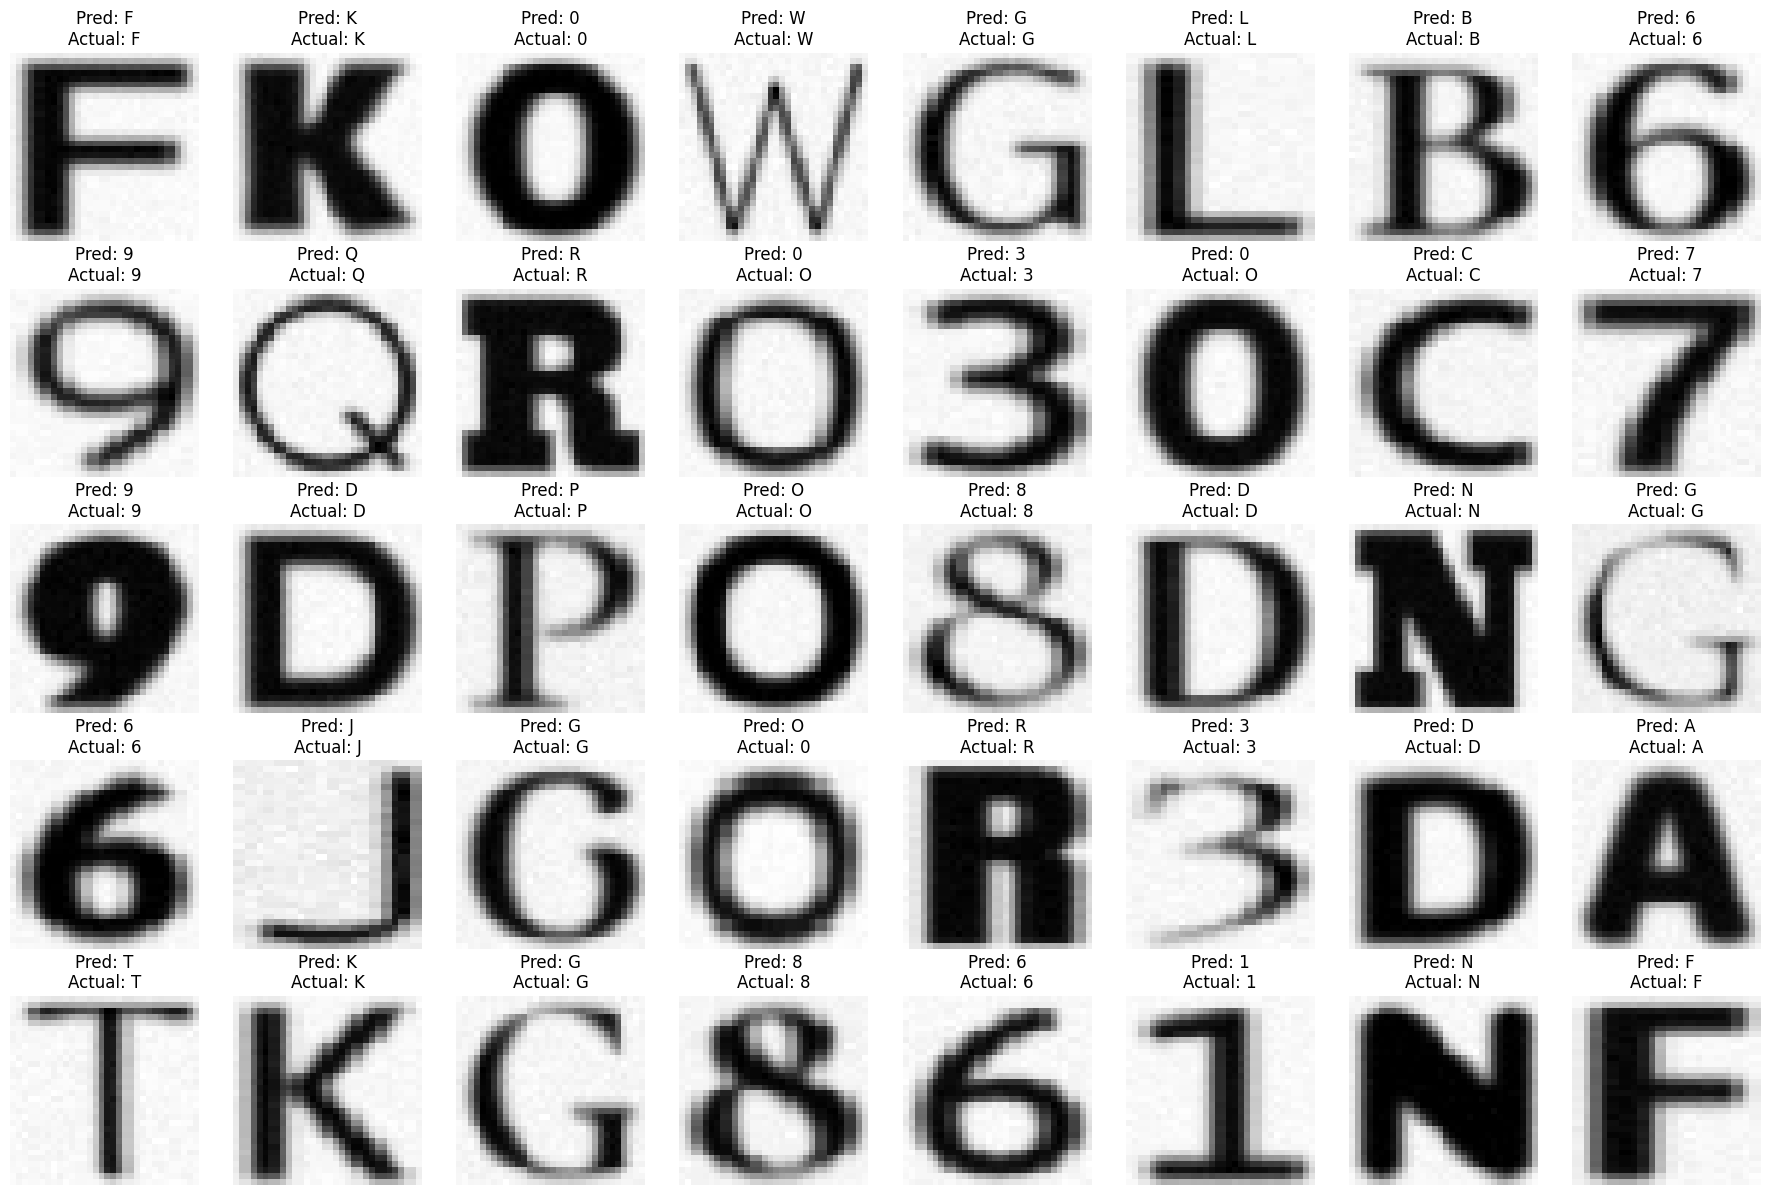

In [32]:
# Visualize 30 random predictions with images
plt.figure(figsize=(18, 12))
for i, idx in enumerate(random.sample(range(len(X_test)), 40)):
    plt.subplot(5, 8, i + 1)  # 5 rows, 6 columns = 30 images
    plt.imshow(X_test[idx].reshape(32, 32), cmap="gray")
    plt.title(f"Pred: {predicted_chars[idx]}\nActual: {actual_chars[idx]}", fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()



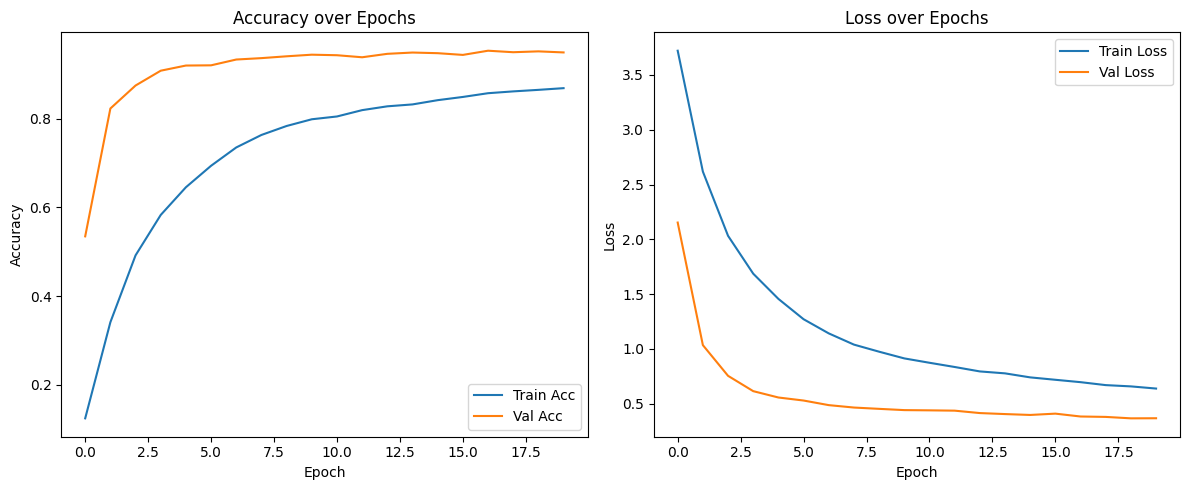

In [23]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Processing: detected_regions/220px-Indian_Vehicle_Registration_Plate_-_Kolkata_2011-07-29_4088_(cropped).jpeg


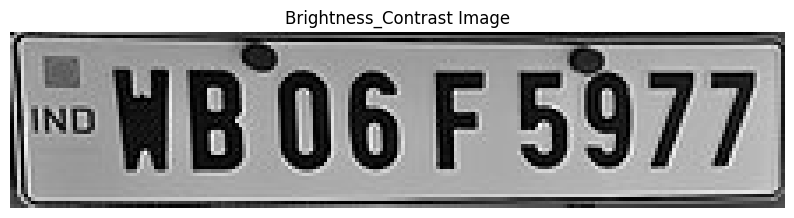

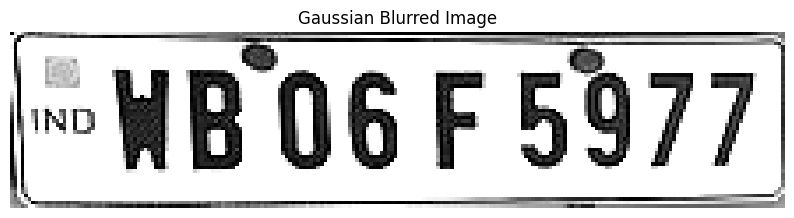

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


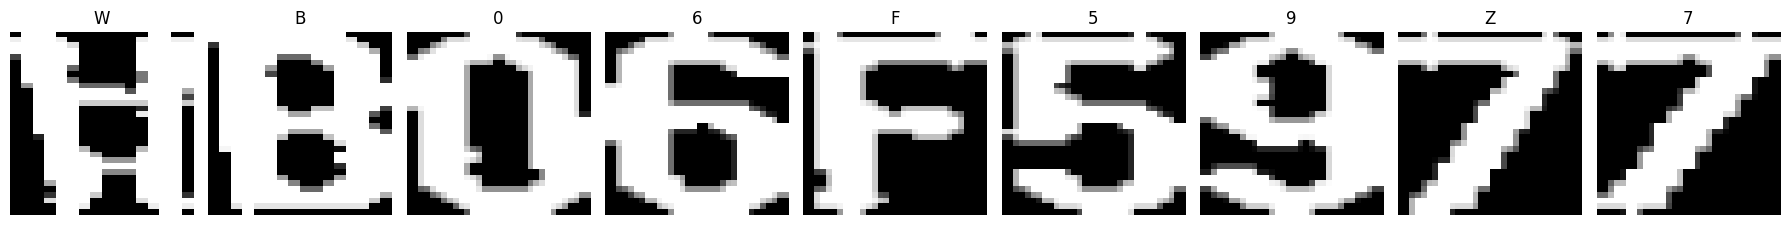

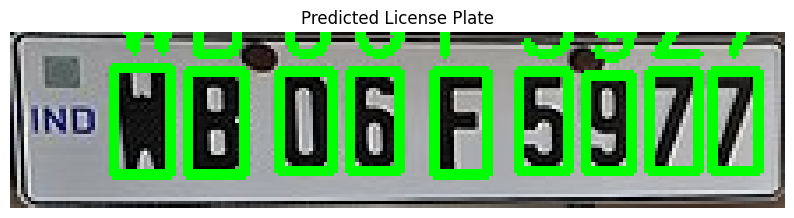

🔤 Predicted License Plate: WB06F59Z7
Processing: detected_regions/car4.jpeg_region_1.jpg


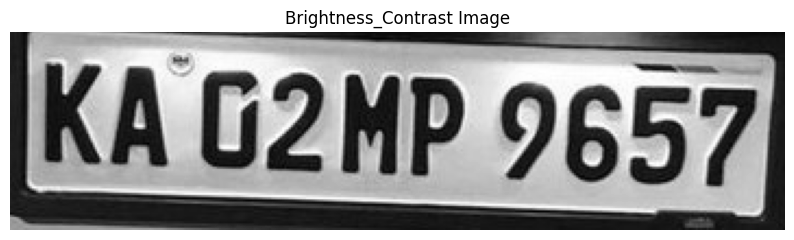

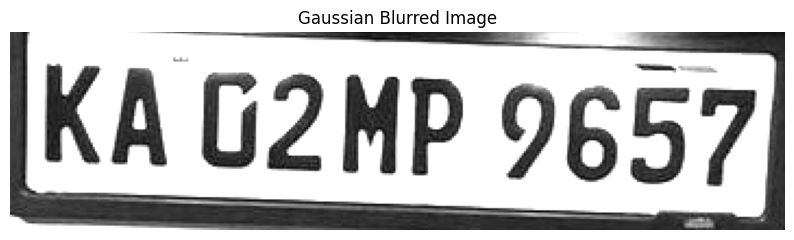

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


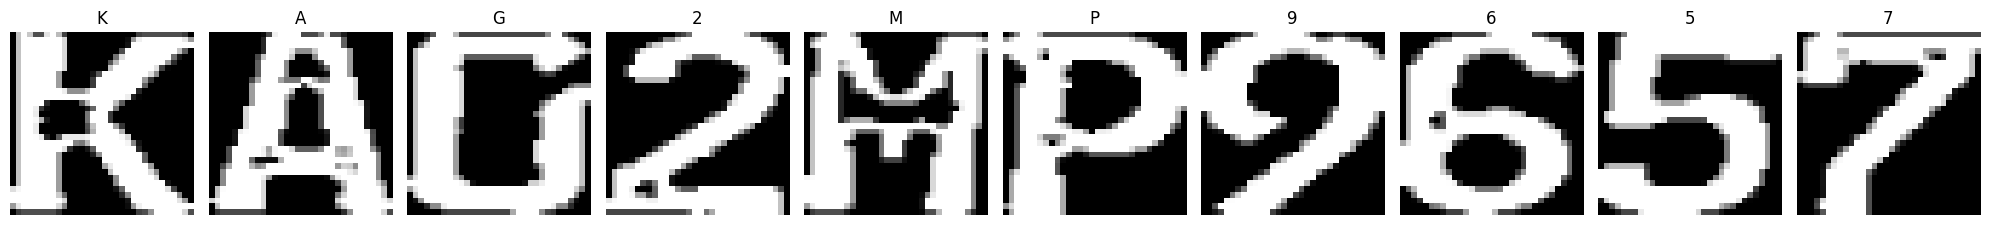

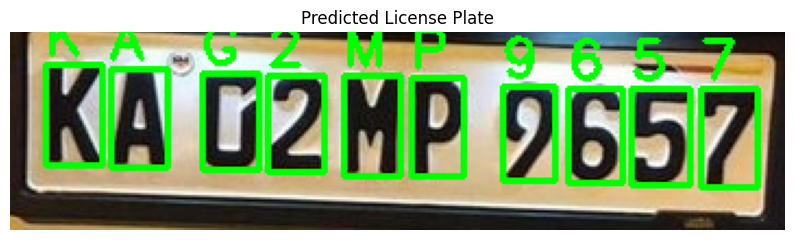

🔤 Predicted License Plate: KAG2MP9657
Processing: detected_regions/car5.jpg_region_1.jpg


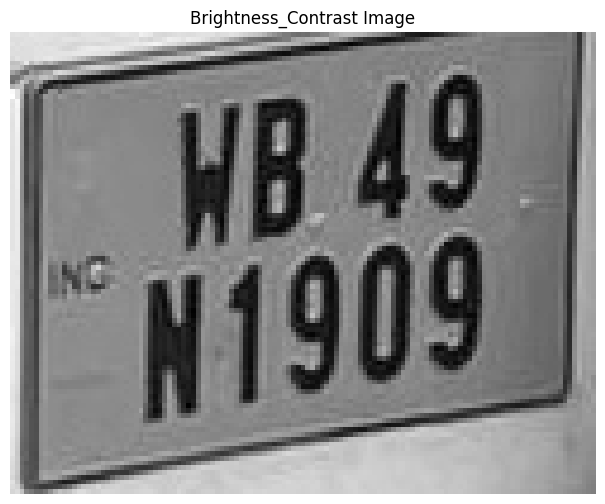

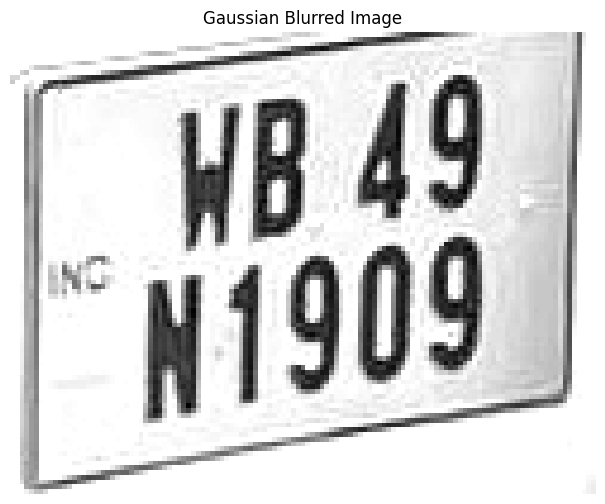

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


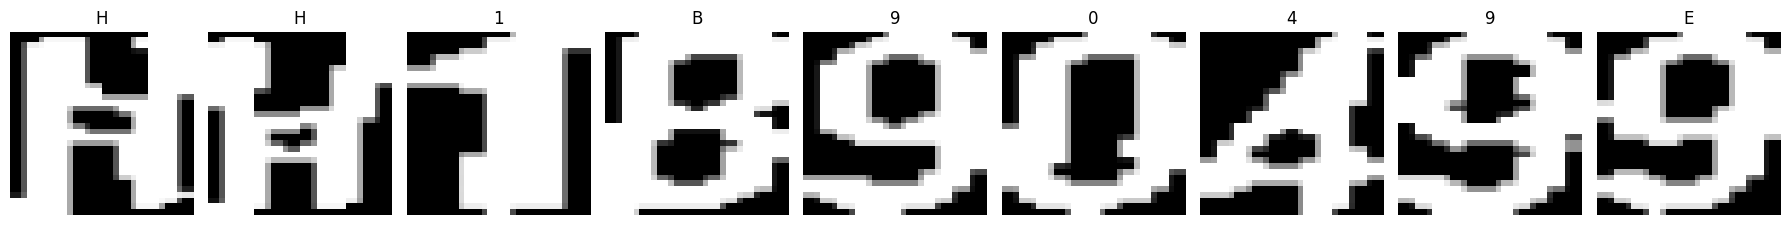

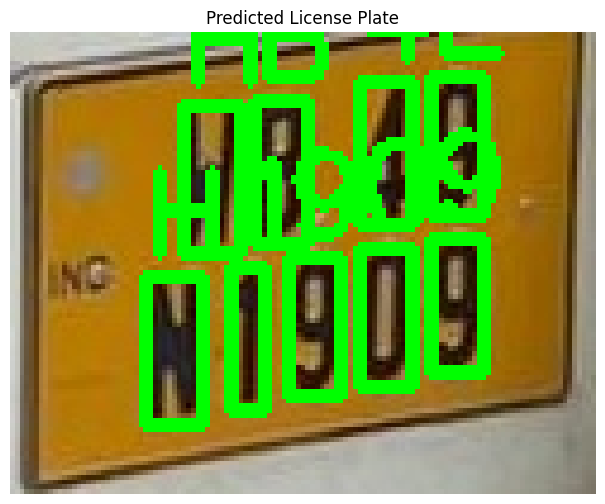

🔤 Predicted License Plate: HH1B9049E
Processing: detected_regions/ind_hr98e1732_close.jpg


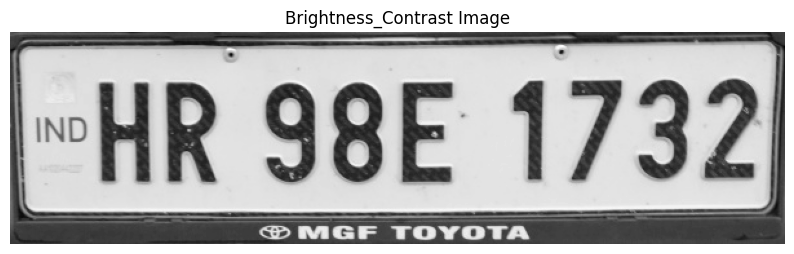

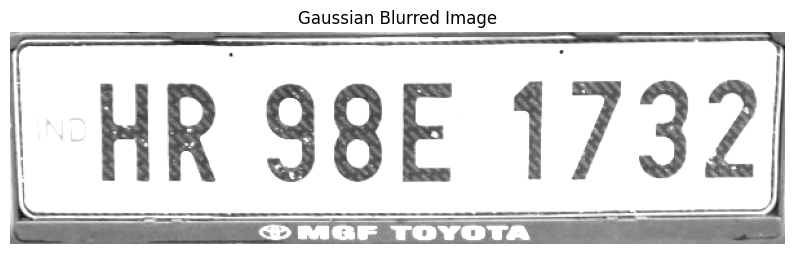

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


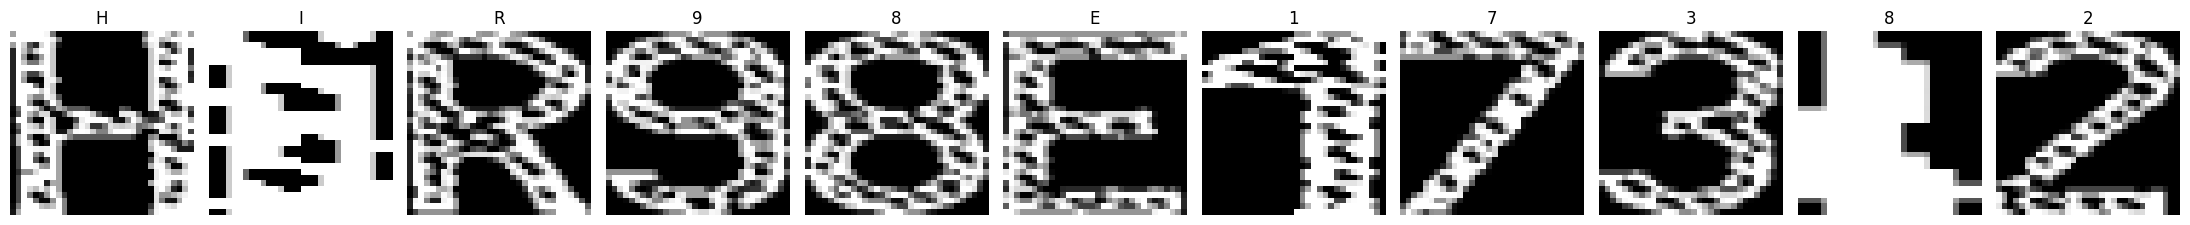

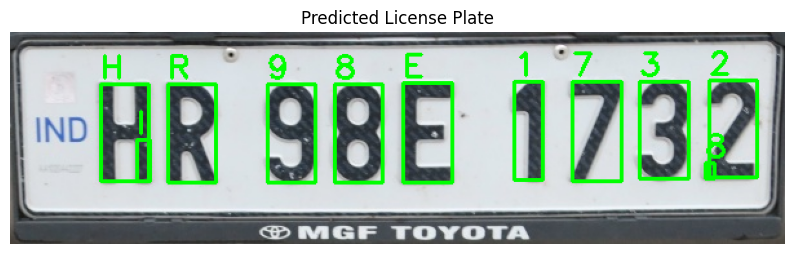

🔤 Predicted License Plate: HIR98E17382
Processing: detected_regions/sample.jpg_region_1.jpg


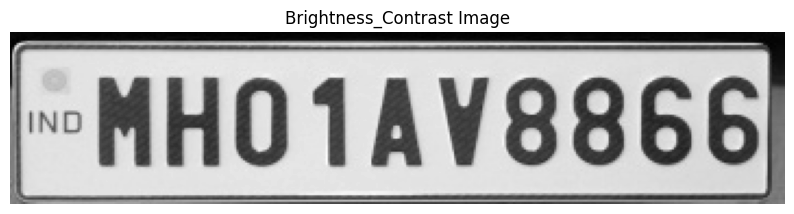

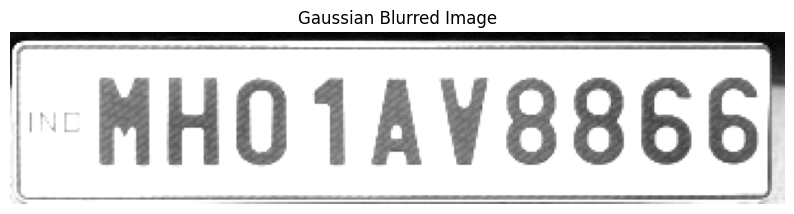

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


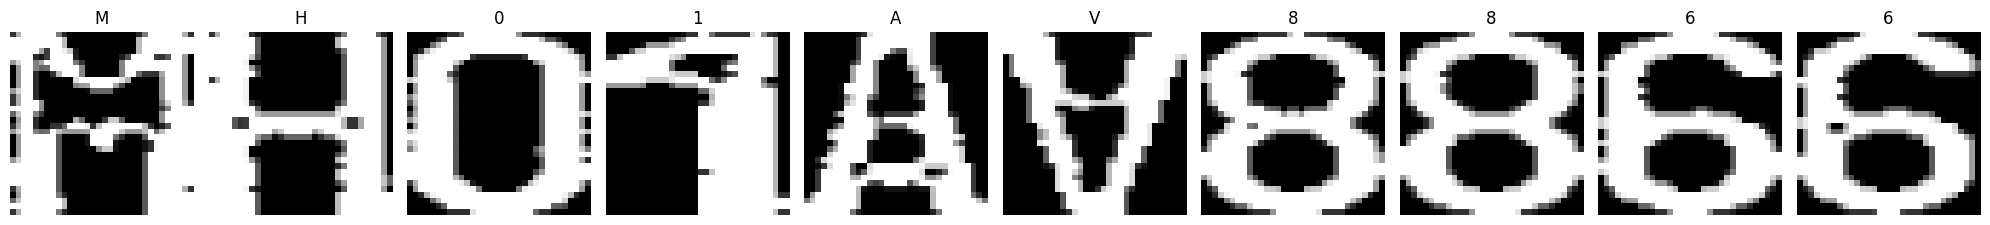

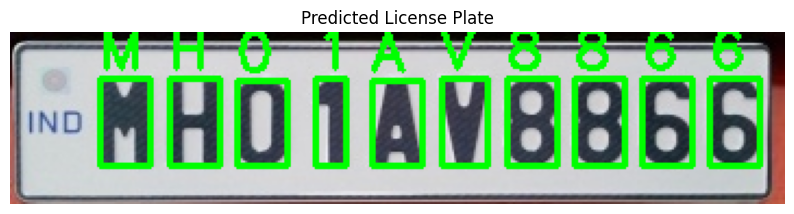

🔤 Predicted License Plate: MH01AV8866
Processing: detected_regions/WhatsApp Image 2025-04-26 at 11.29.26_3d9a9f3e.jpg_region_1.jpg


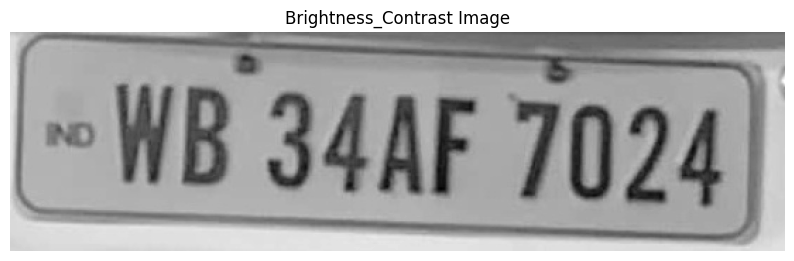

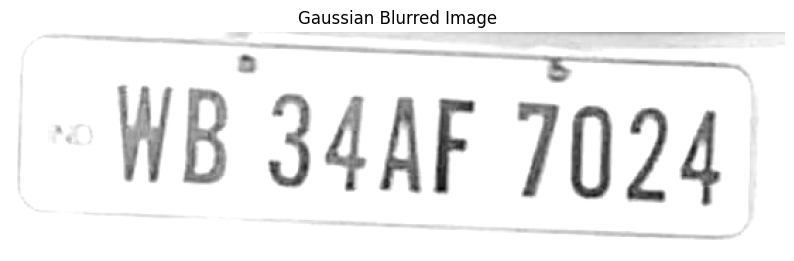

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


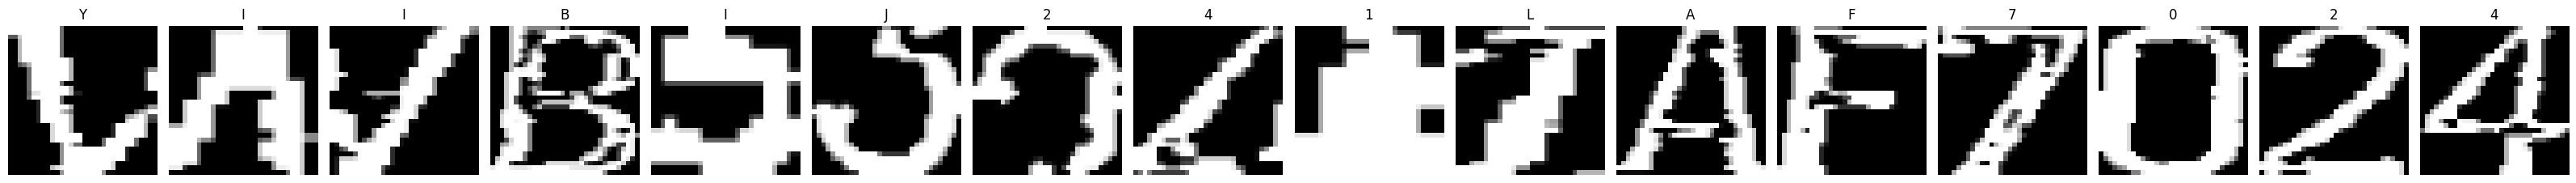

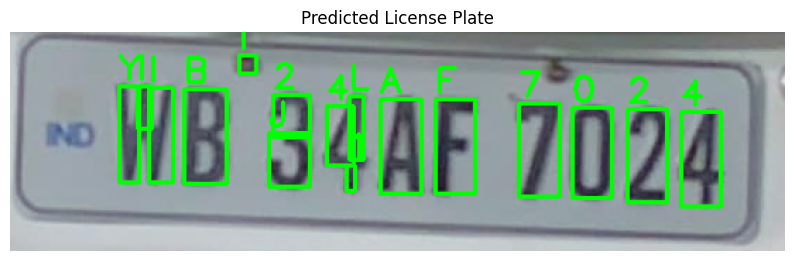

🔤 Predicted License Plate: YIIBIJ241LAF7024
Processing: detected_regions/WhatsApp Image 2025-05-02 at 00.05.39_ce2cd07e.jpg_region_1.jpg


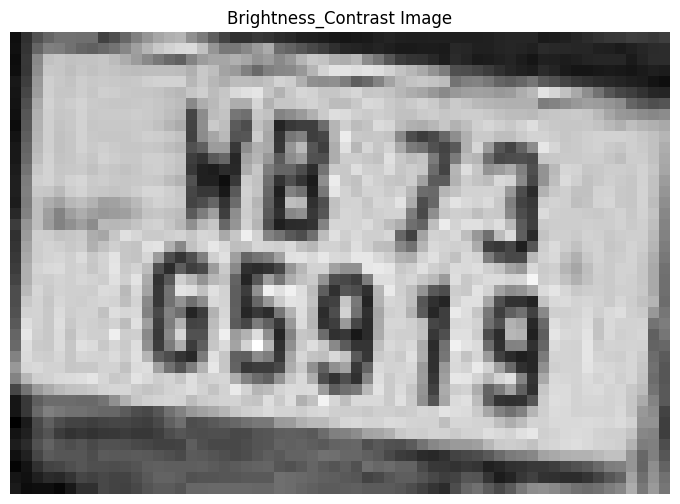

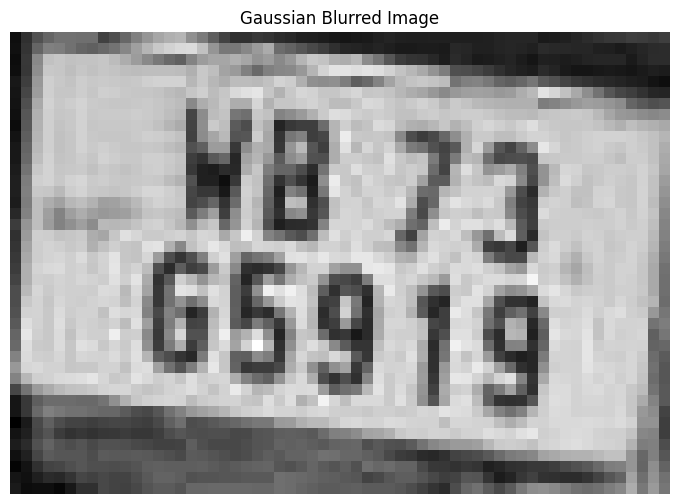

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


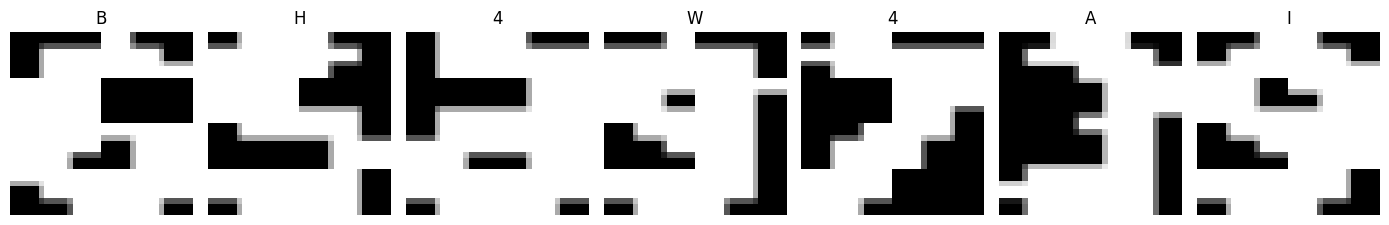

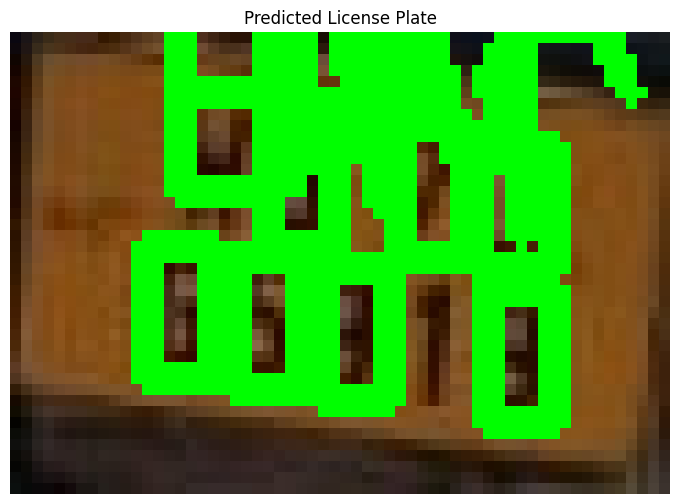

🔤 Predicted License Plate: BH4W4AI
Processing: detected_regions/WhatsApp Image 2025-05-02 at 00.05.39_ce2cd07e.jpg_region_2.jpg


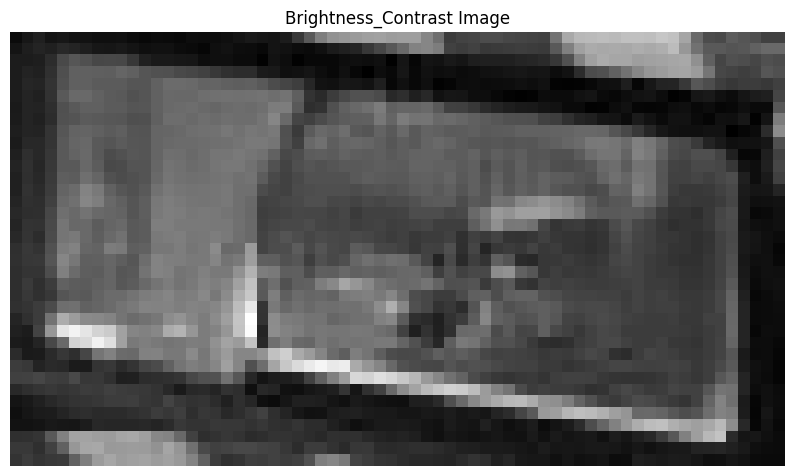

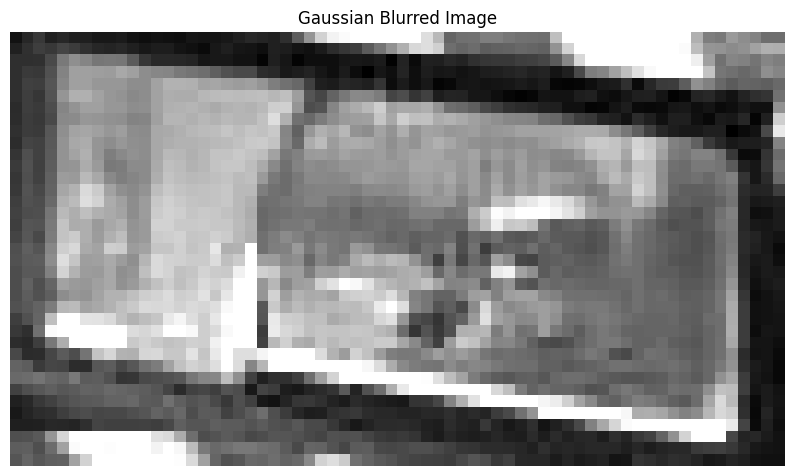

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


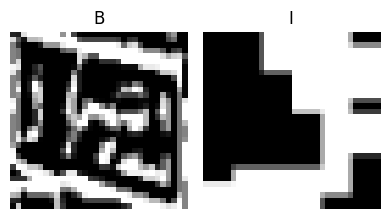

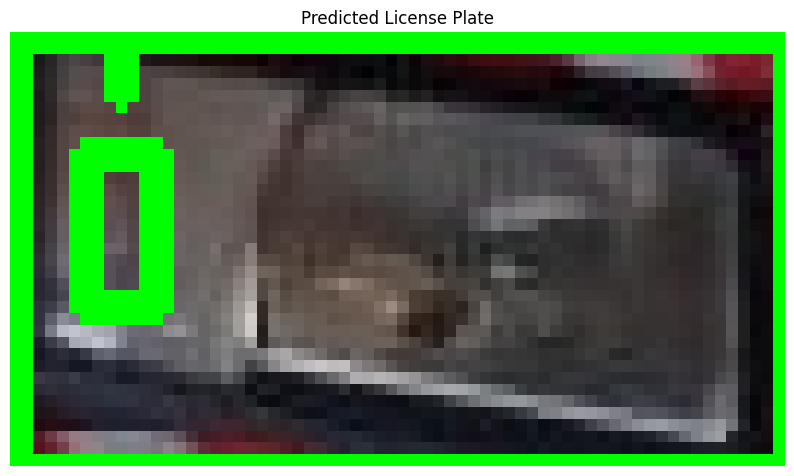

🔤 Predicted License Plate: BI
Processing: detected_regions/WhatsApp Image 2025-05-02 at 00.06.05_a83ed625.jpg_region_1.jpg


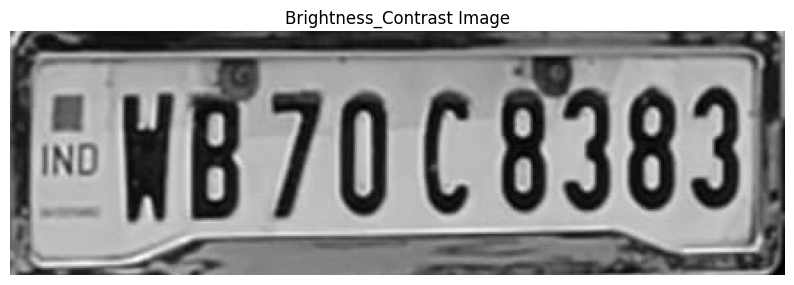

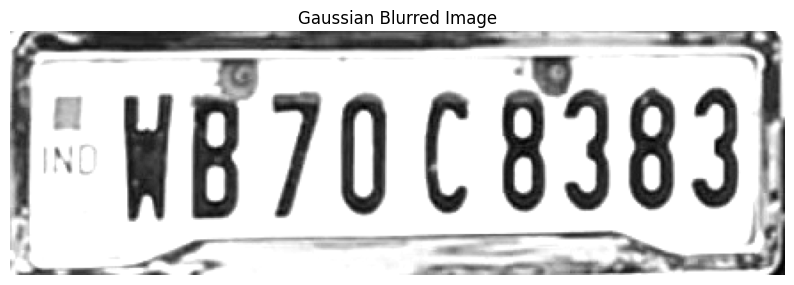

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


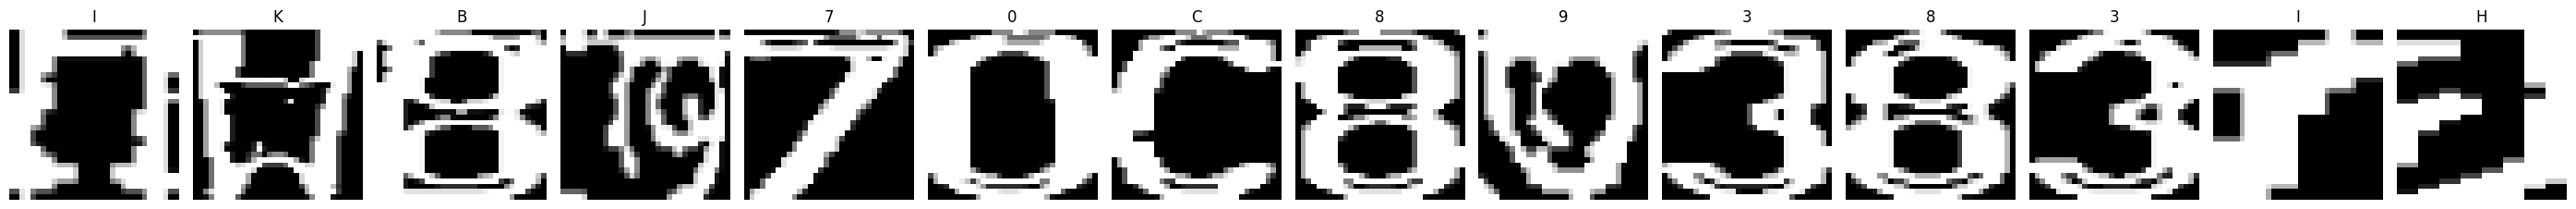

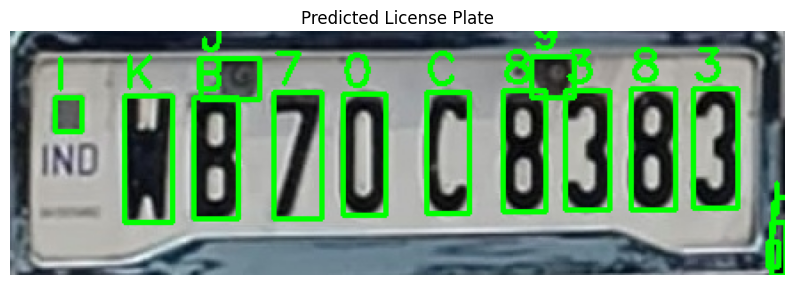

🔤 Predicted License Plate: IKBJ70C89383IH
Processing: detected_regions/WhatsApp Image 2025-05-02 at 00.06.05_a83ed625.jpg_region_2.jpg


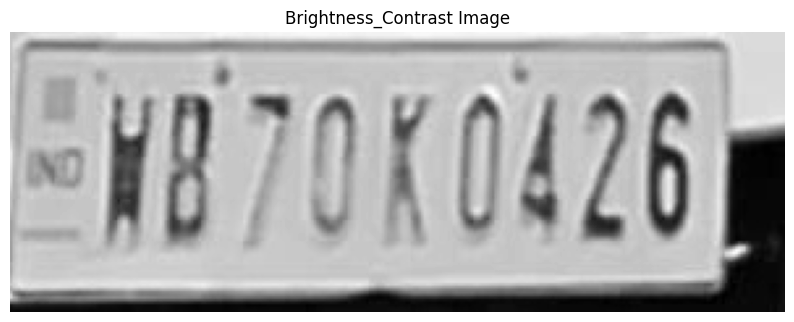

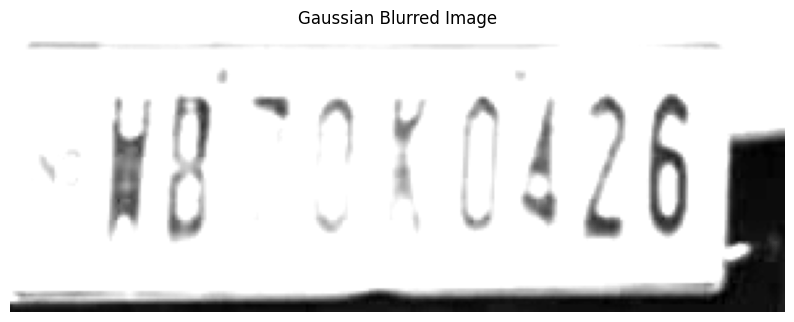

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


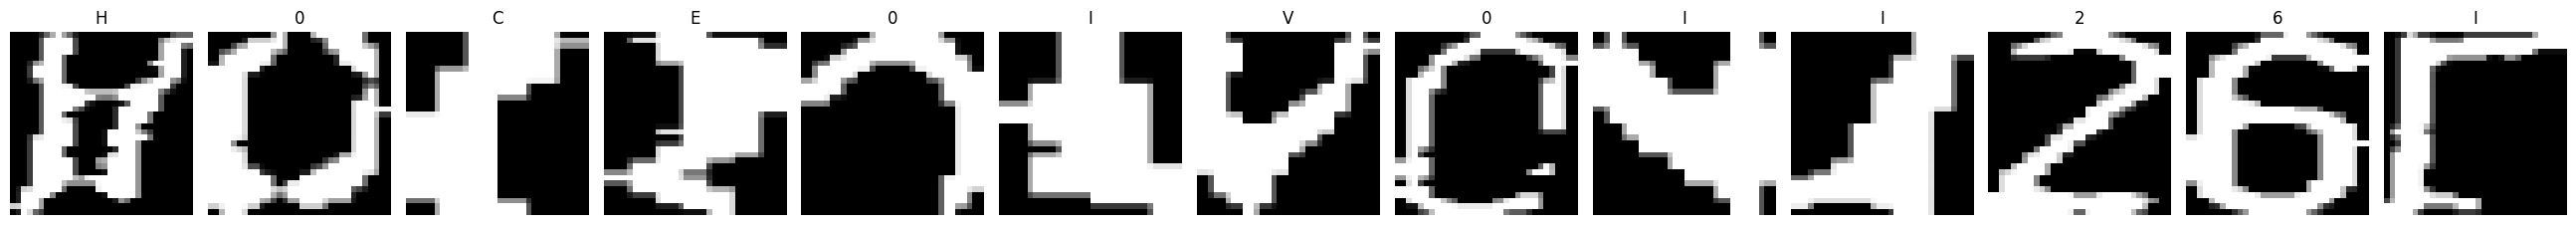

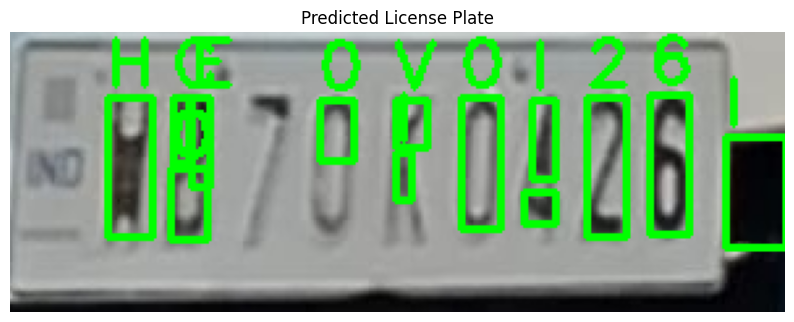

🔤 Predicted License Plate: H0CE0IV0II26I
Processing: detected_regions/WhatsApp Image 2025-05-06 at 21.07.34_8cc9f13e.jpg_region_1.jpg


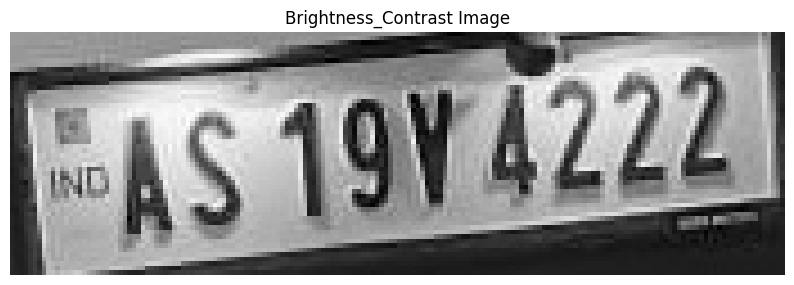

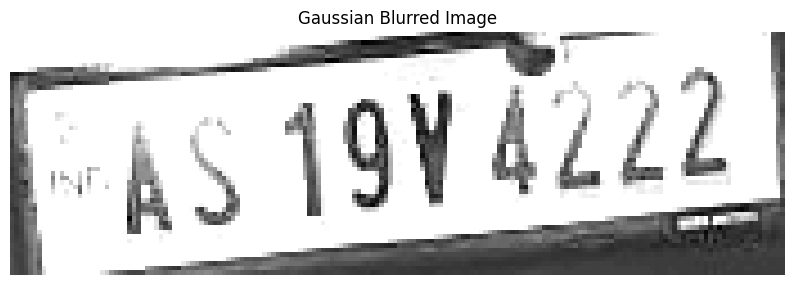

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


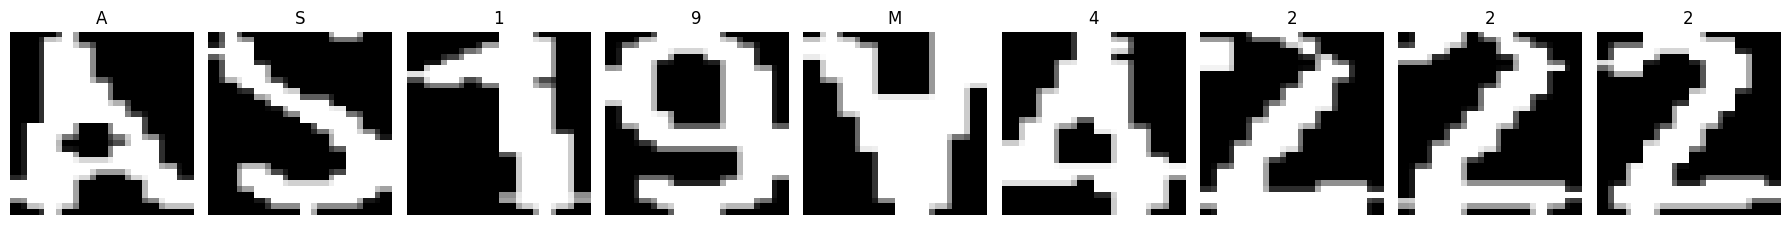

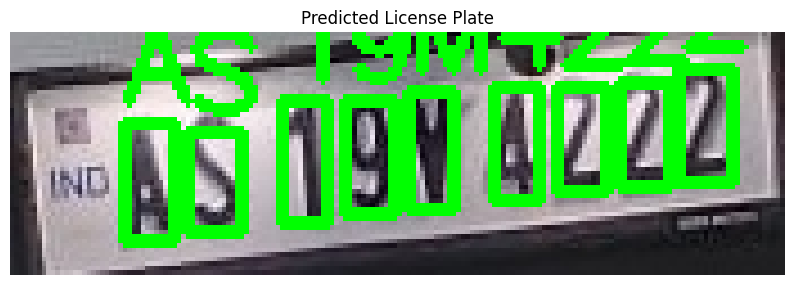

🔤 Predicted License Plate: AS19M4222
Processing: detected_regions/WhatsApp Image 2025-05-06 at 21.07.34_8dac0cea.jpg_region_1.jpg


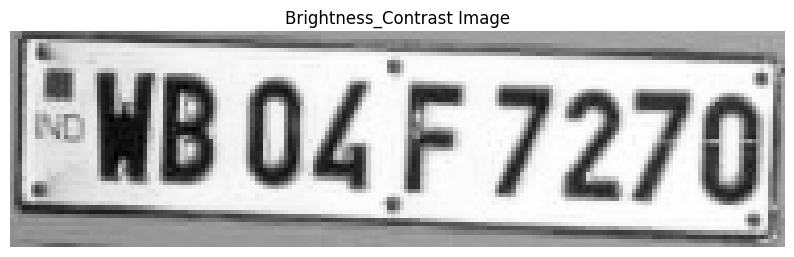

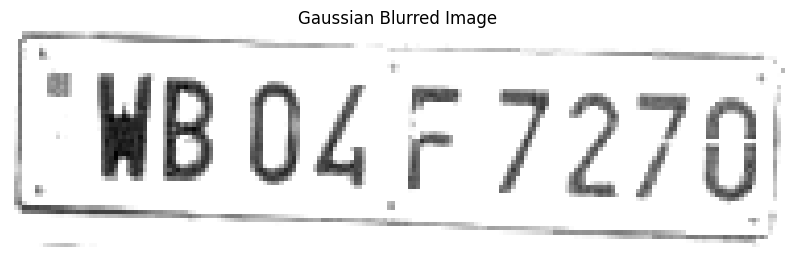

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


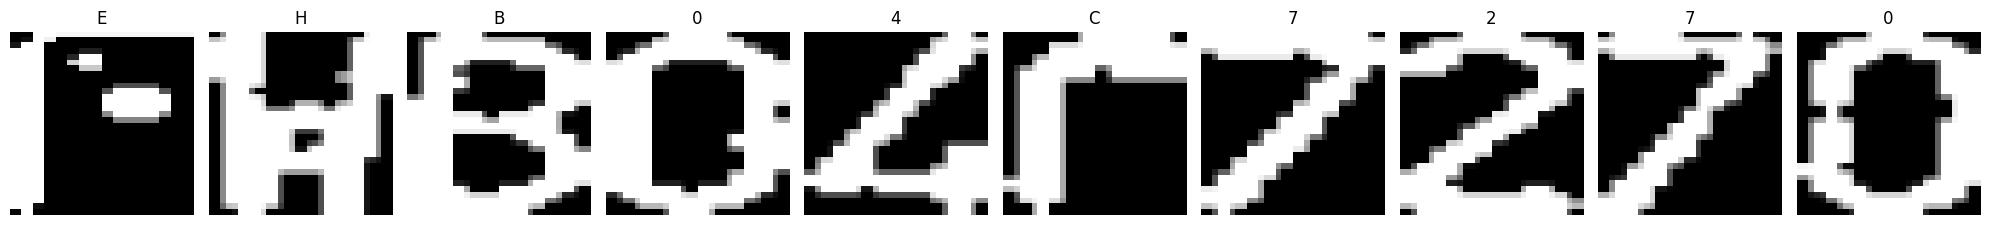

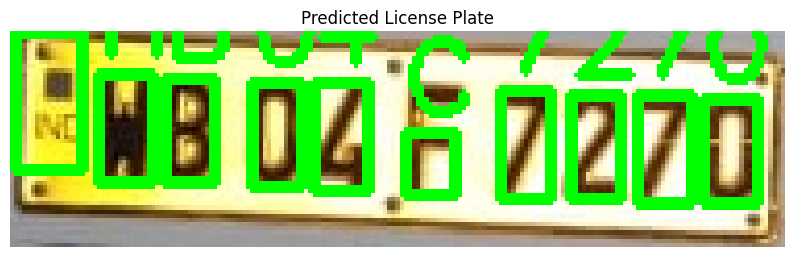

🔤 Predicted License Plate: EHB04C7270
Processing: detected_regions/WhatsApp Image 2025-05-06 at 21.07.34_cbb09866.jpg_region_1.jpg


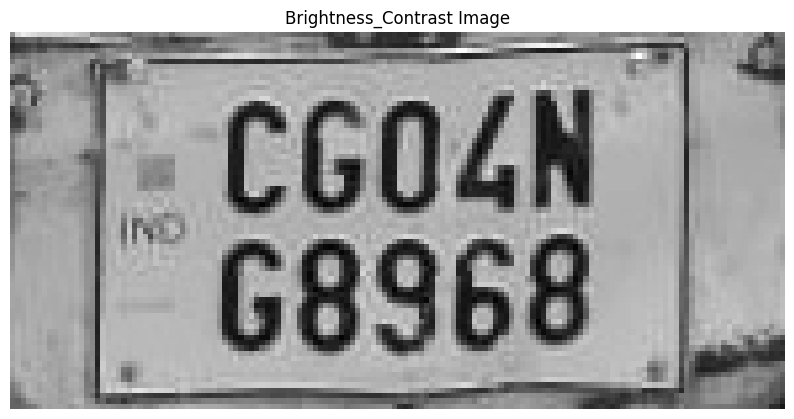

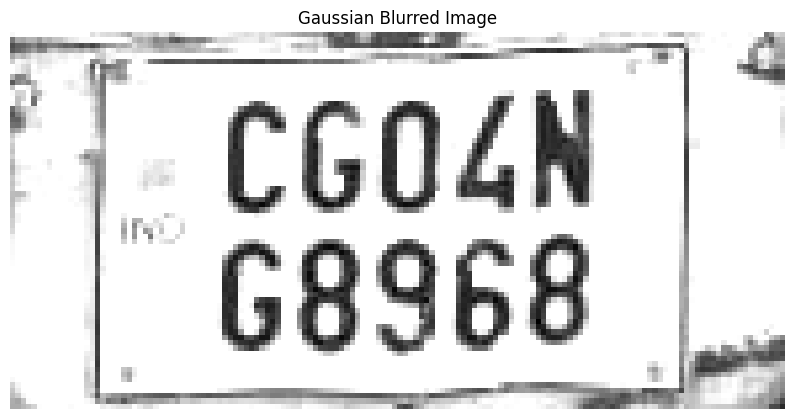

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


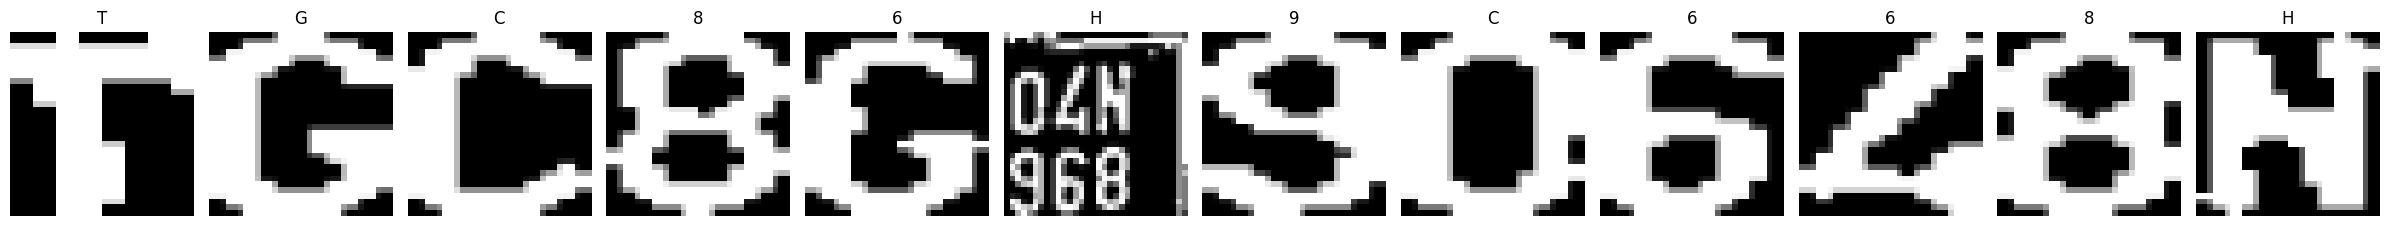

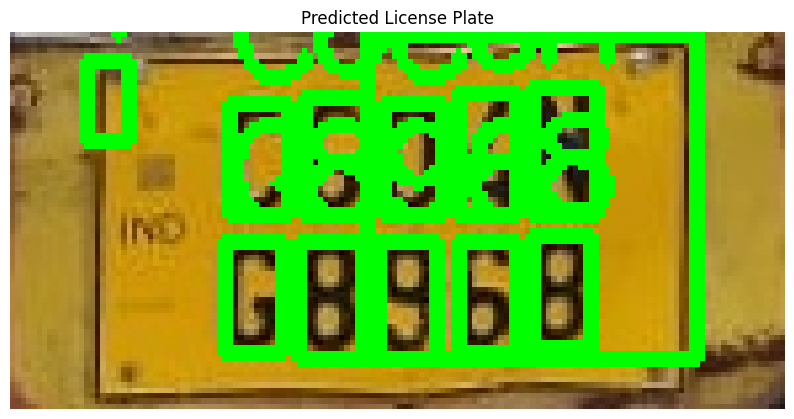

🔤 Predicted License Plate: TGC86H9C668H


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load trained model
model_path = "D:\WORKSPACE\College Project\YOLO+CNN\CNN\ocr_model_kaggle.keras"  # Update this
model = load_model(model_path)

# Mapping integers to characters
char_to_int = {char: i for i, char in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")}
int_to_char = {i: char for char, i in char_to_int.items()}  # Reverse mapping

# Folder containing images
plates_folder = "detected_regions/"  # Replace with your folder path

def show_step(title, image, cmap='gray'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.show()

# Image pre-processing function for character prediction
def preprocess_character(char_img):
    char_img = cv2.resize(char_img, (32, 32))  # Resize to CNN input size
    char_img = char_img / 255.0  # Normalize
    char_img = np.expand_dims(char_img, axis=-1)  # Add channel dimension

    return char_img

# Function to adjust brightness and contrast
def adjust_brightness_contrast(image, alpha=2.0, beta=5):
    show_step("Brightness_Contrast Image", image)
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Function to display an image
def show_step(title, image, cmap='gray'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.show()

# Function to process and segment characters from an image
def process_and_segment(image_path):
    print(f"Processing: {image_path}")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading {image_path}. Skipping.")
        return [], image  # Return original image for debugging

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Adjust brightness and contrast
    adjusted_image = adjust_brightness_contrast(gray, alpha=2.0, beta=5)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(adjusted_image, (3, 3), 3)
    show_step("Gaussian Blurred Image", adjusted_image)

    # Convert to binary using adaptive thresholding
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 8
    )

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and segment characters
    segmented_characters = []
    bounding_boxes = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter contours by size and aspect ratio
        aspect_ratio = w / h
        if 5 < w < 100 and 10 < h < 100 and 0.2 < aspect_ratio < 2:
            # Extract character
            character = binary[y:y + h, x:x + w]

            # Resize for consistency
            resized_character = cv2.resize(character, (32, 32), interpolation=cv2.INTER_AREA)

            segmented_characters.append(resized_character)
            bounding_boxes.append((x, y, w, h))

    # Sort characters from left to right
    if segmented_characters:
        bounding_boxes, segmented_characters = zip(
            *sorted(zip(bounding_boxes, segmented_characters), key=lambda b: b[0][0])
        )

    return list(segmented_characters), image, bounding_boxes



def pad_and_crop_char(image, bbox, pad=4):
    x, y, w, h = bbox
    x1 = max(x - pad, 0)
    y1 = max(y - pad, 0)
    x2 = min(x + w + pad, image.shape[1])
    y2 = min(y + h + pad, image.shape[0])

    cropped = image[y1:y2, x1:x2]
    resized = cv2.resize(cropped, (32, 32), interpolation=cv2.INTER_AREA)

    norm_img = resized.astype("float32") / 255.0
    norm_img = np.expand_dims(norm_img, axis=-1)
    norm_img = np.expand_dims(norm_img, axis=0)
    return norm_img


# Function to predict characters and visualize results
def predict_and_visualize(segmented_chars, original_image, bounding_boxes):
    plate_text = ""

    # Create a figure to show each character alongside its prediction
    fig, axes = plt.subplots(1, len(segmented_chars), figsize=(len(segmented_chars) * 2, 4))
    if len(segmented_chars) == 1:
        axes = [axes]  # Ensure iterable if there's only one character

    for idx, (char_img, bbox) in enumerate(zip(segmented_chars, bounding_boxes)):
        # processed_img = preprocess_character(char_img)
        # processed_img = np.expand_dims(processed_img, axis=0)  # Add batch dimension
        processed_img = pad_and_crop_char(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), bbox)

        # Predict
        pred = model.predict(processed_img)
        predicted_label = np.argmax(pred)  # Get the predicted class index
        predicted_char = int_to_char.get(predicted_label, "?")  # Convert index to character
        plate_text += predicted_char

        # Display character with prediction
        axes[idx].imshow(char_img, cmap='gray')
        axes[idx].axis("off")
        axes[idx].set_title(f"{predicted_char}")

        # Draw predicted character on original image
        x, y, w, h = bbox
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(original_image, predicted_char, (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    plt.tight_layout()
    plt.show()

    # Show the original plate with bounding boxes and predictions
    show_step("Predicted License Plate", cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), cmap=None)

    return plate_text

# Process and predict for all license plates
for plate_file in os.listdir(plates_folder):
    plate_path = os.path.join(plates_folder, plate_file)
    if not os.path.isfile(plate_path):
        continue

    # Segment characters
    segmented_characters, original_image, bounding_boxes = process_and_segment(plate_path)
    if not segmented_characters:
        print(f"No characters segmented in {plate_file}.")
        continue

    # Predict characters and visualize
    predicted_text = predict_and_visualize(segmented_characters, original_image, bounding_boxes)
    print(f"🔤 Predicted License Plate: {predicted_text}")


**A new model**

In [42]:
import pandas as pd
import os
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                    Dropout, BatchNormalization, GlobalAveragePooling2D,
                                    Add, LeakyReLU, Input)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

# --- Dataset Download ---

dataset_path = "/root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2"


# --- Data Loading & Preprocessing ---
training_data = os.path.join(dataset_path, "training_data")
testing_data = os.path.join(dataset_path, "testing_data")

# Create DataFrame with image paths and labels
data = []
for label in os.listdir(training_data):
    label_path = os.path.join(training_data, label)
    if os.path.isdir(label_path):
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            data.append((img_path, label))

df = pd.DataFrame(data, columns=["image_path", "label"])

# Character mapping
characters = list(string.digits + string.ascii_uppercase)
char_to_int = {char: i for i, char in enumerate(characters)}
num_classes = len(characters)
int_to_char = {i: char for char, i in char_to_int.items()}

# Image parameters
IMG_SIZE = (32, 32)

def load_images(df):
    images, labels = [], []
    for _, row in df.iterrows():
        img = keras.utils.load_img(row["image_path"], target_size=IMG_SIZE, color_mode="grayscale")
        img_array = keras.utils.img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(char_to_int[row["label"]])
    return np.array(images), np.array(labels)

X_train, y_train = load_images(df)
X_train = X_train.reshape(-1, *IMG_SIZE, 1)
y_train = to_categorical(y_train, num_classes)

# Train-Validation Split
y_int_labels = np.argmax(y_train, axis=1)
X_train, X_val, y_train_int, y_val_int = train_test_split(
    X_train, y_int_labels, test_size=0.2, stratify=y_int_labels, random_state=42
)
y_train = to_categorical(y_train_int, num_classes)
y_val = to_categorical(y_val_int, num_classes)

# --- Enhanced Model Architecture ---
def residual_block(x, filters, downsample=False):
    shortcut = x
    stride = 2 if downsample else 1

    x = Conv2D(filters, (3,3), padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters, (1,1), strides=2)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    return LeakyReLU(alpha=0.1)(x)

def build_model(input_shape=(32,32,1)):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, (3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    x = residual_block(x, 256, downsample=True)

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
    x = Dropout(0.6)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_model()

# --- Training Configuration ---
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')]
)

# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=False  # Usually bad for characters
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# --- Training ---
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.1117 - loss: 3.8566 - precision: 0.5196 - recall: 0.0037 - val_accuracy: 0.0829 - val_loss: 4.3141 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4195 - loss: 2.4964 - precision: 0.7444 - recall: 0.1042 - val_accuracy: 0.6958 - val_loss: 1.7035 - val_precision: 0.8935 - val_recall: 0.3010 - learning_rate: 1.0000e-04
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6369 - loss: 1.7428 - precision: 0.8356 - recall: 0.3538 - val_accuracy: 0.8800 - val_loss: 1.0349 - val_precision: 0.9582 - val_recall: 0.7276 - learning_rate: 1.0000e-04
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7502 - loss: 1.3304 - precision: 0.8843 - recall: 0.5703 - val_accuracy: 0.9154 - val_loss: 0.7810 - val_precision: 0.9670 - val_recall: 0.8597 - learning_rate: 1.0000e-04
Epoch 5/100
258/258 ━━━━━━━━

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7b88c17a8180>

In [43]:
model.save('cnn.keras')

In [44]:
def load_test_images(testing_data_path):
    test_images = []
    test_filenames = []
    actual_labels = []

    for label in os.listdir(testing_data_path):
        label_path = os.path.join(testing_data_path, label)

        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
                    img_array = img_to_array(img) / 255.0
                    test_images.append(img_array)
                    test_filenames.append(img_path)
                    actual_labels.append(label)
                except Exception as e:
                    print(f"⚠️ Skipped invalid test image: {img_path} ({e})")

    return np.array(test_images), test_filenames, actual_labels

In [46]:
X_test, test_filenames, actual_labels = load_test_images(testing_data)
X_test = X_test.reshape(-1, 32, 32, 1)

⚠️ Skipped invalid test image: /root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2/testing_data/G/44404.png (cannot identify image file <_io.BytesIO object at 0x7b8893df1bc0>)


In [47]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


In [48]:
int_to_char = {i: c for c, i in char_to_int.items()}
predicted_chars = [int_to_char[i] for i in y_pred_labels]


In [50]:
actual_chars = [label for label in actual_labels]
correct = np.sum(np.array(predicted_chars) == np.array(actual_chars))
accuracy = (correct / len(actual_chars)) * 100
print(f"✅ Test Accuracy: {accuracy:.2f}%")

✅ Test Accuracy: 98.33%


⚠️ Skipped invalid test image: /root/.cache/kagglehub/datasets/preatcher/standard-ocr-dataset/versions/2/data2/testing_data/G/44404.png (cannot identify image file <_io.BytesIO object at 0x7b8888e62b10>)
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

✅ Final Test Accuracy: 98.33%


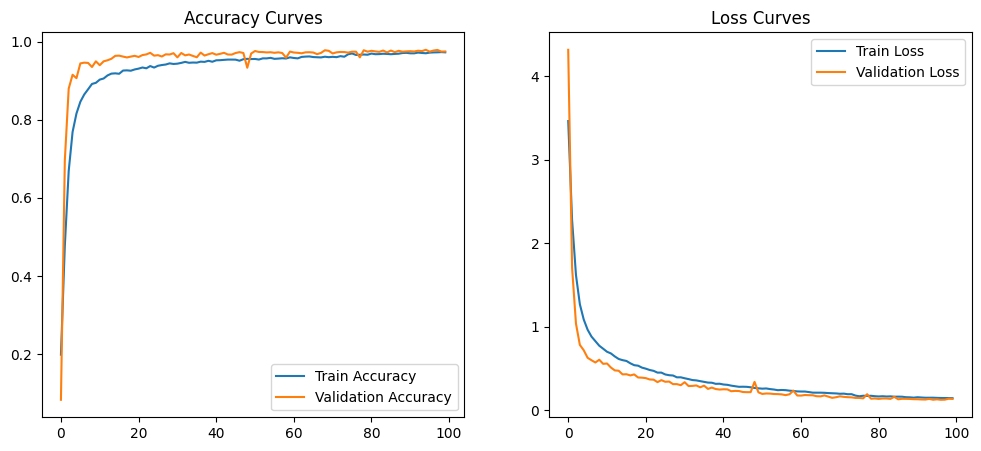

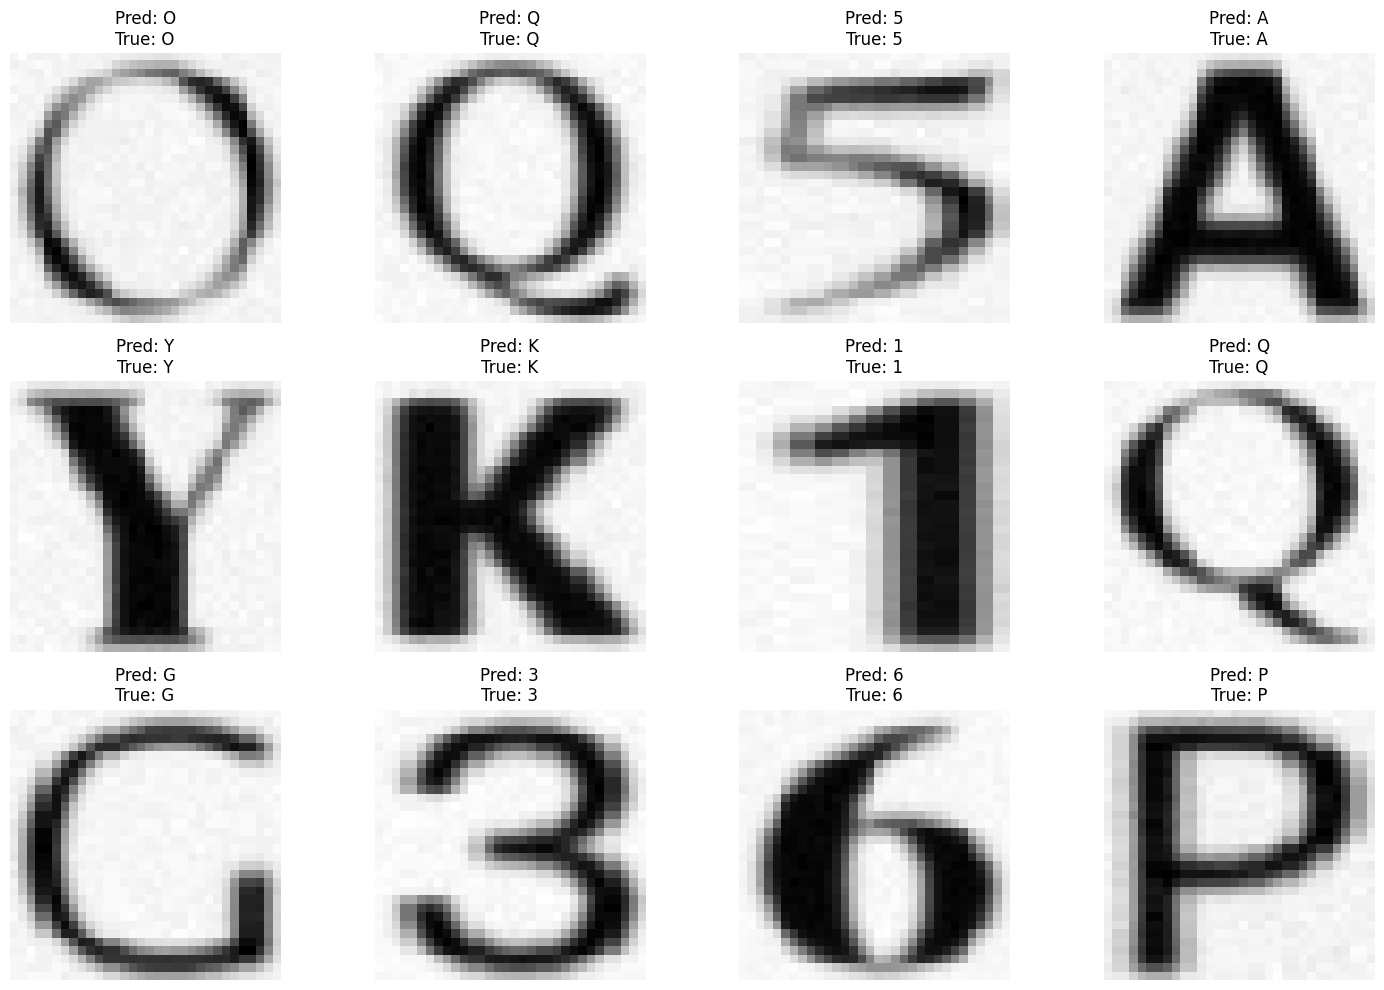

In [51]:
X_test, test_files, y_true = load_test_images(testing_data)
X_test = X_test.reshape(-1, *IMG_SIZE, 1)

# Predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
predicted_chars = [int_to_char[i] for i in y_pred_labels]

# Metrics
accuracy = np.mean(np.array(predicted_chars) == np.array(y_true)) * 100
print(f"\n✅ Final Test Accuracy: {accuracy:.2f}%")

# --- Visualization ---
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Sample predictions
plt.figure(figsize=(15, 10))
for i in range(12):
    idx = np.random.randint(len(X_test))
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.title(f"Pred: {predicted_chars[idx]}\nTrue: {y_true[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

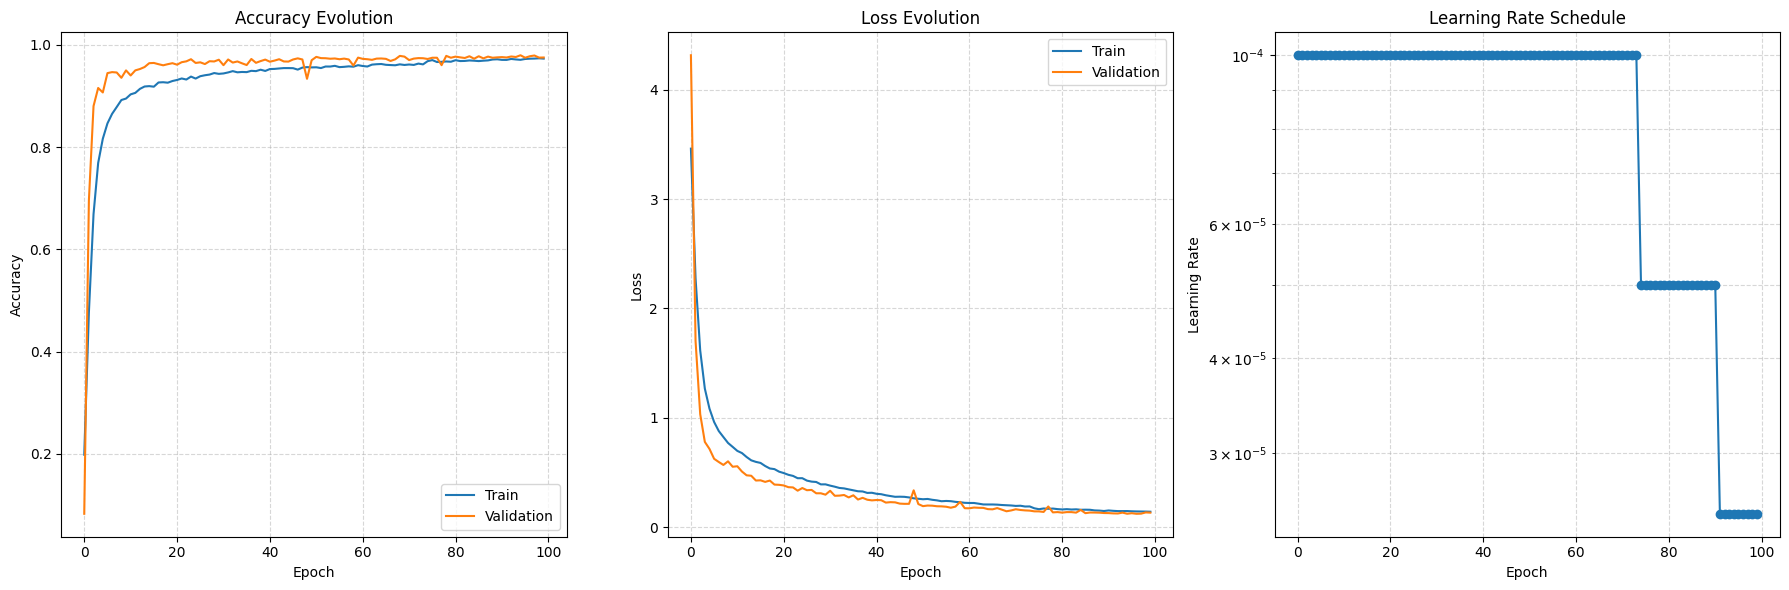

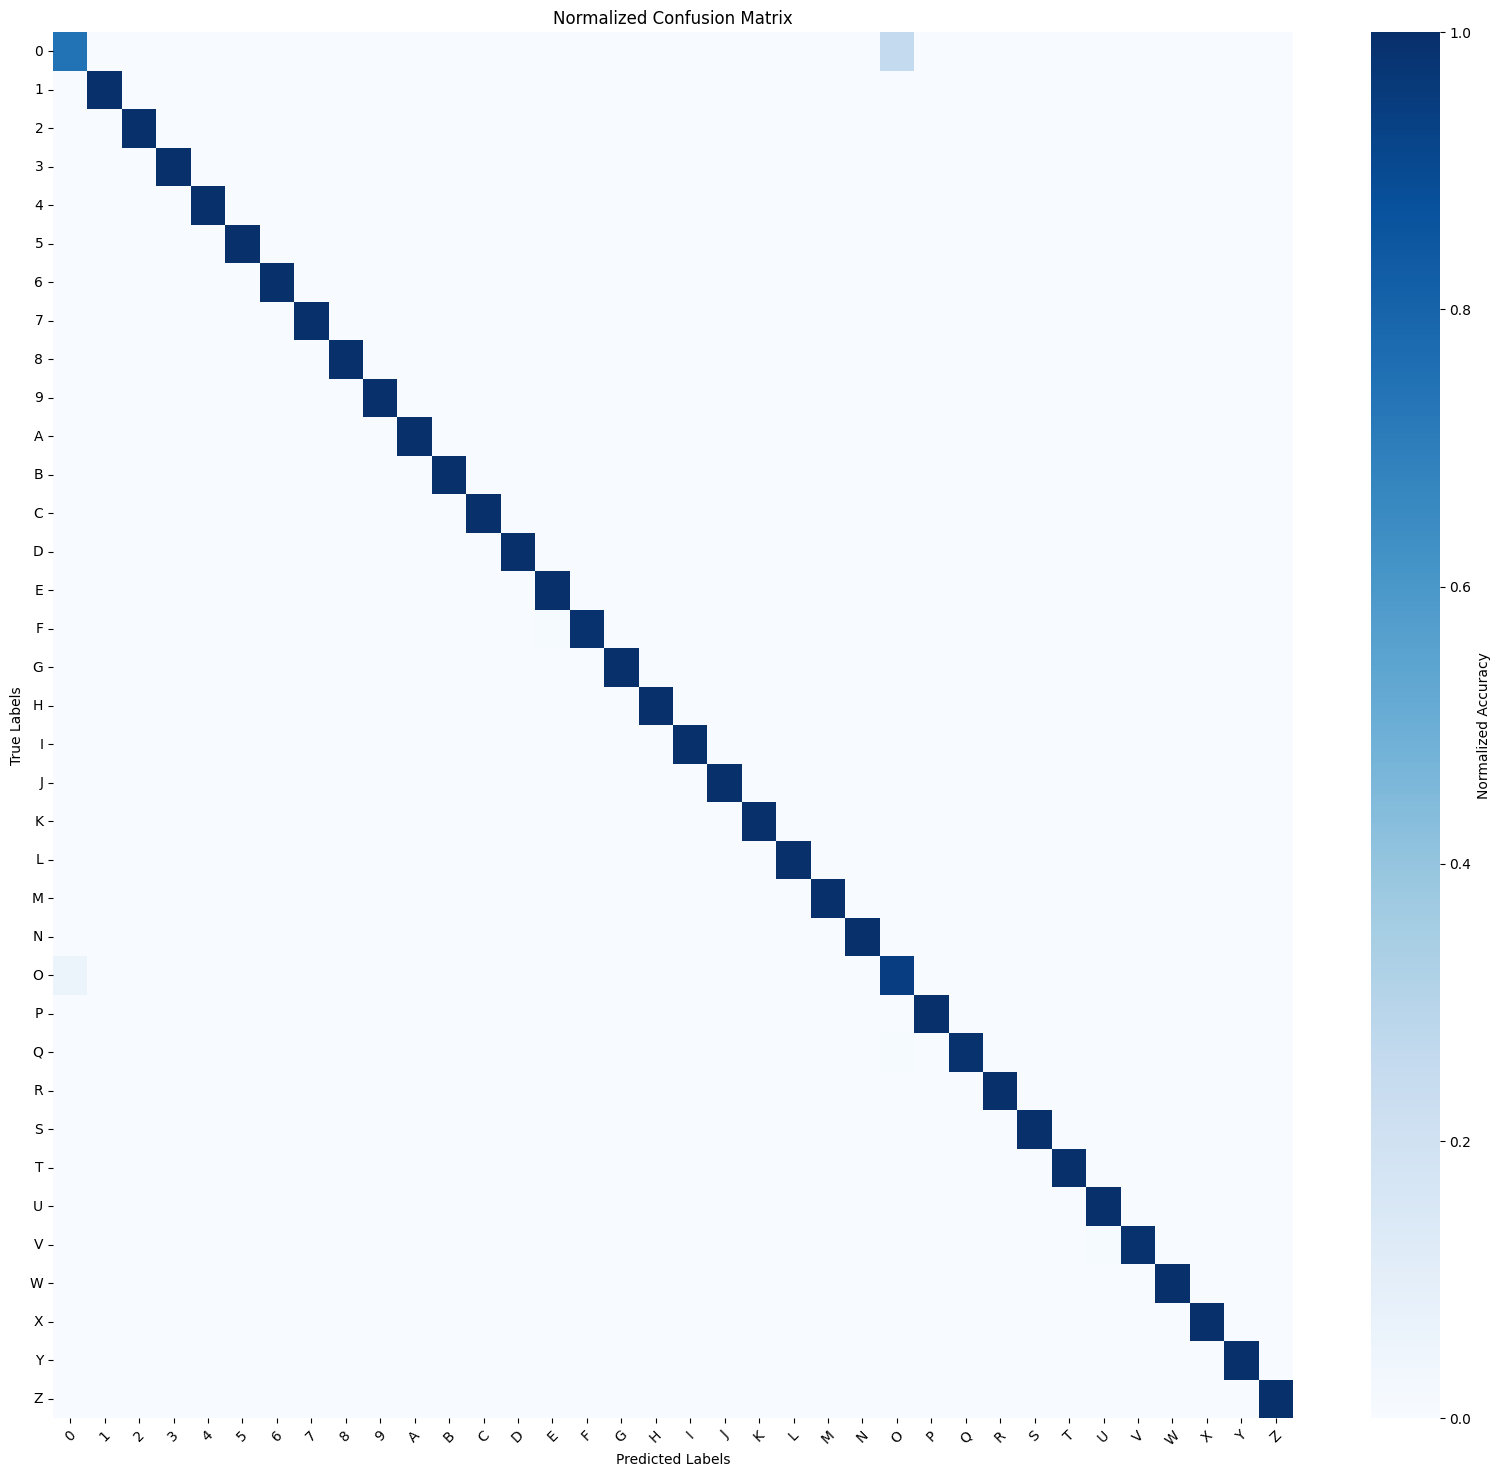

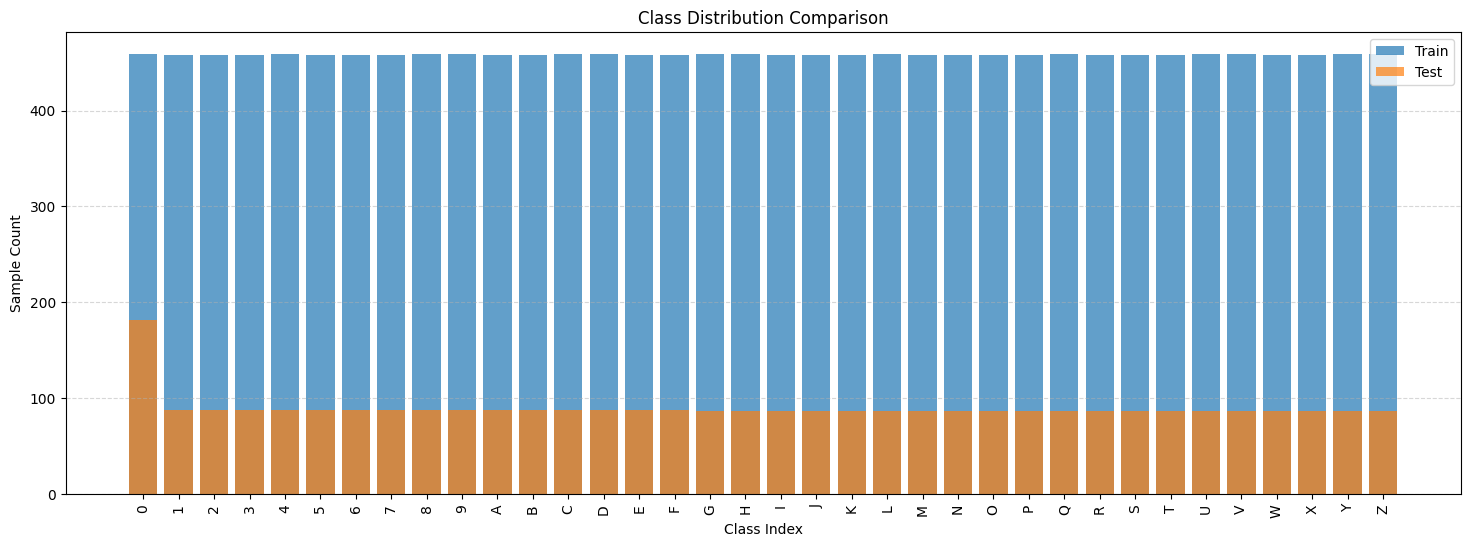

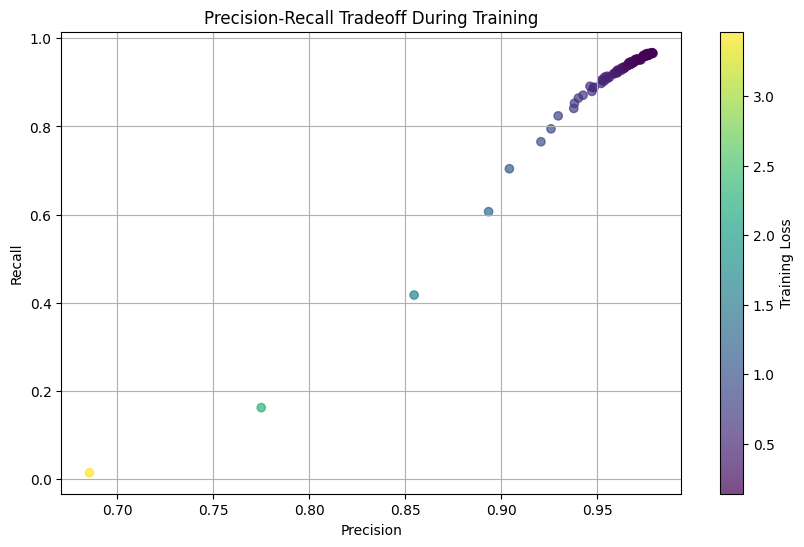

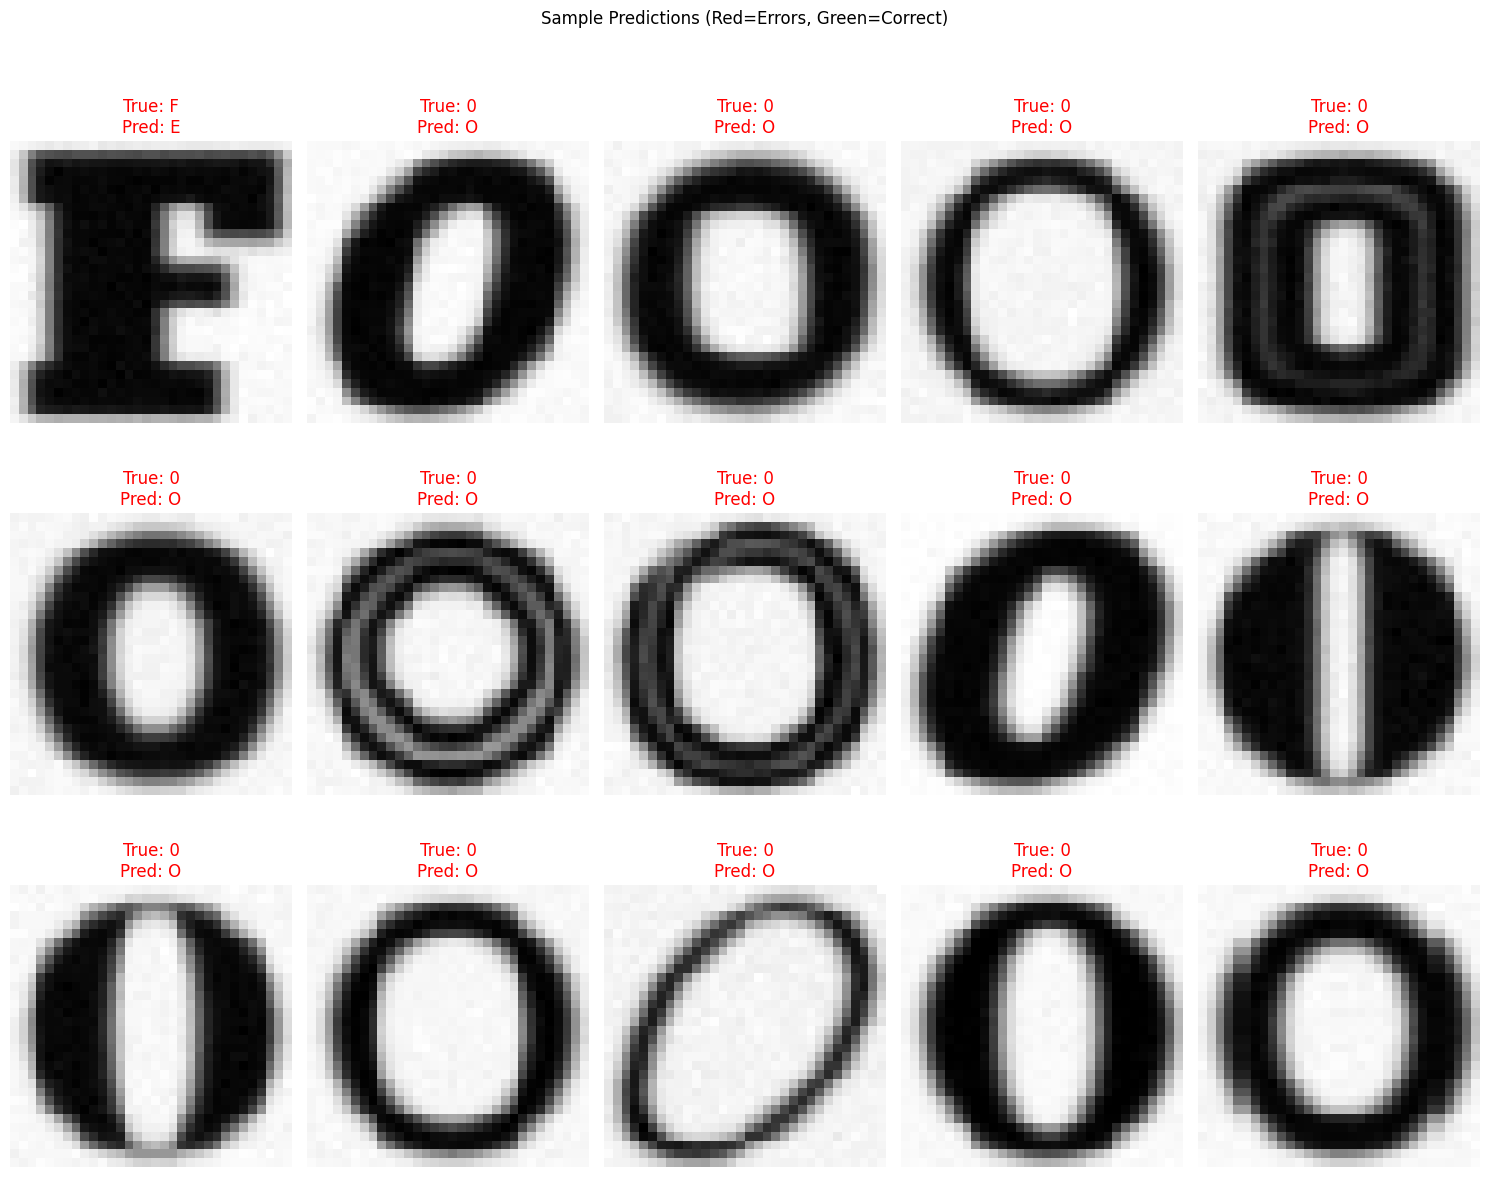


Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.746     0.841       181
           1      1.000     1.000     1.000        88
           2      1.000     1.000     1.000        88
           3      1.000     1.000     1.000        88
           4      1.000     1.000     1.000        88
           5      1.000     1.000     1.000        88
           6      1.000     1.000     1.000        88
           7      1.000     1.000     1.000        88
           8      1.000     1.000     1.000        88
           9      1.000     1.000     1.000        88
           A      1.000     1.000     1.000        88
           B      1.000     1.000     1.000        88
           C      1.000     1.000     1.000        88
           D      1.000     1.000     1.000        88
           E      0.989     1.000     0.994        88
           F      1.000     0.989     0.994        88
           G      1.000     1.000     1.000        87
   

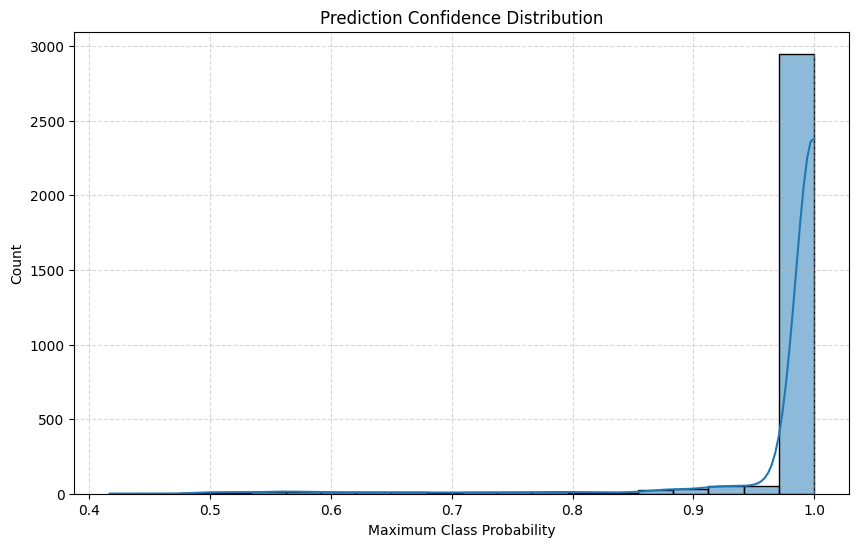

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Training History Plots ---
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Learning Rate Plot
plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], marker='o')
plt.title('Learning Rate Schedule')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- 2. Confusion Matrix ---
plt.figure(figsize=(20, 18))
cm = confusion_matrix(y_true, predicted_chars, labels=characters)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=False, cmap='Blues',
           cbar_kws={'label': 'Normalized Accuracy'},
           xticklabels=characters, yticklabels=characters)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# --- 3. Class Distribution Analysis ---
# Training Data Distribution
train_counts = np.bincount(y_train_int)
# Test Data Distribution
test_counts = [y_true.count(c) for c in characters]

plt.figure(figsize=(18, 6))
plt.bar(range(num_classes), train_counts, alpha=0.7, label='Train')
plt.bar(range(num_classes), test_counts, alpha=0.7, label='Test')
plt.title('Class Distribution Comparison')
plt.xlabel('Class Index')
plt.ylabel('Sample Count')
plt.xticks(range(num_classes), characters, rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- 4. Precision-Recall Analysis ---
plt.figure(figsize=(10, 6))
plt.scatter(history.history['precision'], history.history['recall'],
           c=history.history['loss'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Training Loss')
plt.title('Precision-Recall Tradeoff During Training')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

# --- 5. Error Analysis: Sample Predictions ---
plt.figure(figsize=(15, 12))
num_samples = 15
incorrect_indices = [i for i, (true, pred) in enumerate(zip(y_true, predicted_chars)) if true != pred]

# If enough errors exist, show errors, else show random samples
display_indices = incorrect_indices[:num_samples] if len(incorrect_indices) >= num_samples else random.sample(range(len(X_test)), num_samples)

for i, idx in enumerate(display_indices):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    title_color = 'red' if y_true[idx] != predicted_chars[idx] else 'green'
    plt.title(f"True: {y_true[idx]}\nPred: {predicted_chars[idx]}", color=title_color)
    plt.axis('off')

plt.suptitle('Sample Predictions (Red=Errors, Green=Correct)', y=1.02)
plt.tight_layout()
plt.show()

# --- 6. Classification Report ---
print("\nClassification Report:")
print(classification_report(y_true, predicted_chars, target_names=characters, digits=3))

# --- 7. Confidence Distribution ---
plt.figure(figsize=(10, 6))
max_probs = np.max(y_pred, axis=1)
sns.histplot(max_probs, bins=20, kde=True)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Maximum Class Probability')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()